In [1]:
# Importing all necessary libraries
import os
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline


# Optional libraries
try:
  import xgboost as xgb
  from xgboost import XGBRegressor
  xgb_available = True
except Exception:
  xgb_available = False

try:
  import lightgbm as lgb
  from lightgbm import LGBMRegressor
  lgb_available = True
except Exception:
  lgb_available = False

try:
  import shap
  shap_available = True
except Exception:
  shap_available = False


print(f"xgboost available: {xgb_available}")
print(f"lightgbm available: {lgb_available}")
print(f"shap available: {shap_available}")


RANDOM_STATE = 42
plt.rcParams['figure.figsize'] = (10, 6)

xgboost available: True
lightgbm available: True
shap available: True


In [2]:
# %%
# ===============================
# Step 1: Load Data
# ===============================
# Update paths if needed
inc_path = "Cancer_Incidence_Snapshot_2010_2014.csv"
mort_path = "Cancer_Mortality_Snapshot_2003_2015.csv"
sdoh_path = "SDOH_Clean_Wide.csv"


for p in (inc_path, mort_path, sdoh_path):
    if not os.path.exists(p):
        raise FileNotFoundError(f"Required file not found: {p}")


inc = pd.read_csv(inc_path)
# Filter incidence years >= 2010
if 'Year' in inc.columns:
    inc = inc[inc['Year'] >= 2010]
mort = pd.read_csv(mort_path)
# Filter mortality years >= 2010
if 'Year' in mort.columns:
    mort = mort[mort['Year'] >= 2010]
sdoh = pd.read_csv(sdoh_path)


print("Raw shapes:")
print("incidence:", inc.shape)
print("mortality:", mort.shape)
print("sdoh:", sdoh.shape)


# Clean PHU names for merging
for df in (inc, mort, sdoh):
    if 'Geography' not in df.columns:
        raise KeyError("Column 'Geography' not found in one of the input files.")
    df['Geography_clean'] = df['Geography'].astype(str).str.strip().str.lower()

Raw shapes:
incidence: (28050, 10)
mortality: (33660, 9)
sdoh: (108, 23)


In [3]:
# Clean PHU names for merging
for df in (inc, mort, sdoh):
    if 'Geography' not in df.columns:
        raise KeyError("Column 'Geography' not found in one of the input files.")
    df['Geography_clean'] = df['Geography'].astype(str).str.strip().str.lower()

In [4]:
# %%
# ===============================
# Step 2: Preprocessing & Aggregation
# ===============================
print("Incidence columns:", inc.columns.tolist())
print("Mortality columns:", mort.columns.tolist())

# Average incidence rate (2010–2014) - use Age_Standardized_Rate
if 'Rate' not in inc.columns:
    raise KeyError("Column 'Rate' not found in incidence file.")


inc_mean = inc.groupby('Geography_clean', as_index=False)['Rate'].mean()
inc_mean.rename(columns={'Rate': 'Incidence_Rate'}, inplace=True)


# Average mortality rate (2011–2015) - using available years
if 'Rate' not in mort.columns:
    raise KeyError("Column 'Rate' not found in mortality file.")


mort_mean = mort.groupby('Geography_clean', as_index=False)['Rate'].mean()
mort_mean.rename(columns={'Rate': 'Mortality_Rate'}, inplace=True)


# Use SDOH snapshot (2016) if Year exists
if 'Year' in sdoh.columns:
    sdoh_2016 = sdoh[sdoh['Year'] == 2016].copy()
    if sdoh_2016.empty:
        print("Warning: No SDOH rows for Year 2016. Using latest available year instead.")
        sdoh_2016 = sdoh.sort_values('Year', ascending=False).drop_duplicates('Geography_clean')
else:
    sdoh_2016 = sdoh.copy()


# Merge
merged = inc_mean.merge(mort_mean, on='Geography_clean', how='inner')
merged = merged.merge(sdoh_2016, on='Geography_clean', how='left')


print(f"Merged shape before dropping NAs: {merged.shape}")


# Drop rows with missing targets or excessive missing values in predictors
# Keep rows where Incidence_Rate and Mortality_Rate are present
merged = merged.dropna(subset=['Incidence_Rate', 'Mortality_Rate'])


# Drop columns that are non-numeric or identifiers except Geography columns and Year
non_numeric = merged.select_dtypes(include=['object', 'category']).columns.tolist()
# Keep Geography columns
non_numeric = [c for c in non_numeric if c not in ('Geography_clean', 'Geography')]


# If a non-numeric column contains numeric-like strings, attempt to coerce
for col in non_numeric:
    try:
        coerced = pd.to_numeric(merged[col], errors='coerce')
        if coerced.notna().sum() / len(coerced) > 0.9: # mostly numeric
            merged[col] = coerced
    except Exception:
        pass


# After coercion, drop entirely non-numeric columns (except Geography)
cols_to_drop = [c for c in merged.columns if merged[c].dtype == 'object' and c not in ('Geography_clean','Geography')]
if cols_to_drop:
    print(f"Dropping non-numeric columns: {cols_to_drop}")
    merged = merged.drop(columns=cols_to_drop)


# Final dropna
merged = merged.dropna()
print(f"Merged shape after cleaning: {merged.shape}")
print("Columns:", list(merged.columns))

Incidence columns: ['Indicator', 'Measure', 'Year', 'Geography', 'Rate', '95% Confidence Interval', 'Cases', 'Population', 'Significant Compared to Ontario', 'Suppression Flag', 'Geography_clean']
Mortality columns: ['Indicator', 'Measure', 'Year', 'Geography', 'Rate', '95% Confidence Interval', 'Count', 'Population', 'Significance Compared to Ontario', 'Geography_clean']
Merged shape before dropping NAs: (54, 26)
Merged shape after cleaning: (54, 26)
Columns: ['Geography_clean', 'Incidence_Rate', 'Mortality_Rate', 'Geography', 'Year', 'Per cent (%) immigrant population', 'Per cent (%) lone parent households', 'Per cent (%) of households spending more than 30% of their income on shelter costs', 'Per cent (%) of the labour force population who are unemployed', 'Per cent (%) of the population in the labour force (participation rate)', 'Per cent (%) of the population living in low income (LICO-AT) - Ages 0 to 17', 'Per cent (%) of the population living in low income (LICO-AT) - Ages 18 to

In [5]:
merged.rename(columns={

    'Per cent (%) immigrant population':'Immigrant rate',
    'Per cent (%) lone parent households': 'Lone parent households rate',
    'Per cent (%) of households spending more than 30% of their income on shelter costs' : 'Households spending more than 30%',
    'Per cent (%) of the labour force population who are unemployed': 'Unemployed labour force rate',
    'Per cent (%) of the population in the labour force (participation rate)': 'Participating labour force rate ',
    'Per cent (%) of the population living in low income (LICO-AT) - Ages 0 to 17': '(LICO-AT) - Ages 0 to 17',
    'Per cent (%) of the population living in low income (LICO-AT) - Ages 18 to 64': '(LICO-AT) - Ages 18 to 64',
    'Per cent (%) of the population living in low income (LICO-AT) - Ages 65+':'(LICO-AT) - Ages 65+' ,
    'Per cent (%) of the population living in low income (LICO-AT) - All ages': '(LICO-AT) - All ages',
    'Per cent (%) of the population living in low income (LIM-AT) - Ages 0 to 17': '(LIM-AT) - Ages 0 to 17',
    'Per cent (%) of the population living in low income (LIM-AT) - Ages 18 to 64':'(LIM-AT) - Ages 18 to 64' ,
    'Per cent (%) of the population living in low income (LIM-AT) - Ages 65+' :' (LIM-AT) - Ages 65+',
    'Per cent (%) of the population living in low income (LIM-AT) - All ages': '(LIM-AT) - All ages',
    'Per cent (%) of the population who are employed':'Rate of employment',
    'Per cent (%) of the population who cannot speak English or French': 'Rate of no English or French speakers',
    'Per cent (%) of the population with a high school diploma or post-secondary degree/diploma/certificate':'Rate of high school or post-secondary graduate',
    'Per cent (%) of the population with a post-secondary degree/diploma/certificate': 'Rate of post-secondary graduate',
    'Per cent (%) of the population without a high school diploma': 'Rate of no high school diploma holders',
    'Per cent (%) recent immigrant population': 'Rate of recent immigrant',
    'Per cent (%) senior population': 'Rate of Senior',
    'Per cent (%) visible minority population': ' Rate of visible minority'

}, inplace=True)

In [6]:
# %%
# ===============================
# Step 3: Feature Matrix
# ===============================
# Define predictors (all SDOH indicators)
exclude_cols = ['Geography_clean', 'Year', 'Incidence_Rate', 'Mortality_Rate', 'Geography']
feature_cols = [c for c in merged.columns if c not in exclude_cols]


if len(feature_cols) == 0:
    raise ValueError('No predictor columns found after excluding identifier/target columns.')


X = merged[feature_cols].copy()
y_inc = merged['Incidence_Rate'].values
y_mort = merged['Mortality_Rate'].values


print(f"Number of features: {X.shape[1]}")


# Check for constant columns and drop
nunique = X.nunique()
constant_cols = nunique[nunique <= 1].index.tolist()
if constant_cols:
    print(f"Dropping constant cols: {constant_cols}")
    X = X.drop(columns=constant_cols)


# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Save feature names for later
feature_names = X.columns.tolist()

Number of features: 21


In [7]:
# %%
# ===============================
# Step 4: Train/Test Split for both targets
# ===============================

# Create DataFrames from X_scaled to preserve original indices for splitting
# This assumes X's index is meaningful and corresponds to the rows of y_inc/y_mort and merged
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=feature_names)

# Perform train_test_split on the DataFrame versions to retain indices
X_train_inc_df, X_test_inc_df, y_train_inc, y_test_inc = train_test_split(
    X_scaled_df, y_inc, test_size=0.2, random_state=RANDOM_STATE
)

X_train_mort_df, X_test_mort_df, y_train_mort, y_test_mort = train_test_split(
    X_scaled_df, y_mort, test_size=0.2, random_state=RANDOM_STATE
)

# Extract the numpy arrays for model training (as models typically expect arrays)
X_train_inc = X_train_inc_df.values
X_test_inc = X_test_inc_df.values
X_train_mort = X_train_mort_df.values
X_test_mort = X_test_mort_df.values

print("Train/Test sizes (incidence):", X_train_inc.shape, X_test_inc.shape)
print("Train/Test sizes (mortality):", X_train_mort.shape, X_test_mort.shape)

Train/Test sizes (incidence): (43, 21) (11, 21)
Train/Test sizes (mortality): (43, 21) (11, 21)


In [8]:
# %%
# ===============================
# Utility: Metrics function
# ===============================


def regression_metrics(y_true, y_pred):
    return {
        'r2': r2_score(y_true, y_pred),
        'mae': mean_absolute_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred))
    }


# Pretty print metrics
def print_metrics(name, metrics):
    print(f"--- {name} ---")
    print(f"R²: {metrics['r2']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"RMSE:{metrics['rmse']:.4f}")

In [9]:
# %%
# ===============================
# Step 5: Baseline Linear Regression
# ===============================
lin = LinearRegression()
lin.fit(X_train_inc, y_train_inc)


y_pred_lin_inc = lin.predict(X_test_inc)
metrics_lin_inc = regression_metrics(y_test_inc, y_pred_lin_inc)
print_metrics('Linear Regression (Incidence)', metrics_lin_inc)


# For mortality
lin_m = LinearRegression()
lin_m.fit(X_train_mort, y_train_mort)


y_pred_lin_mort = lin_m.predict(X_test_mort)
metrics_lin_mort = regression_metrics(y_test_mort, y_pred_lin_mort)
print_metrics('Linear Regression (Mortality)', metrics_lin_mort)

--- Linear Regression (Incidence) ---
R²: 0.6928
MAE: 8.8404
RMSE:10.4007
--- Linear Regression (Mortality) ---
R²: 0.7566
MAE: 3.3465
RMSE:4.6263


In [10]:
# %%
# ===============================
# Step 6: Lasso Regression (Regularized)
# ===============================
param_grid = {'alpha': np.logspace(-4, 1, 20)}


lasso_grid = GridSearchCV(Lasso(max_iter=10000, random_state=RANDOM_STATE), param_grid, cv=5, scoring='r2')
lasso_grid.fit(X_train_inc, y_train_inc)


best_alpha_inc = lasso_grid.best_params_['alpha']
print('Best Lasso alpha (incidence):', best_alpha_inc)


lasso_inc = Lasso(alpha=best_alpha_inc, max_iter=10000, random_state=RANDOM_STATE)
lasso_inc.fit(X_train_inc, y_train_inc)


y_pred_lasso_inc = lasso_inc.predict(X_test_inc)
metrics_lasso_inc = regression_metrics(y_test_inc, y_pred_lasso_inc)
print_metrics('Lasso (Incidence)', metrics_lasso_inc)

Best Lasso alpha (incidence): 0.4832930238571752
--- Lasso (Incidence) ---
R²: 0.7483
MAE: 7.6032
RMSE:9.4141


In [11]:
# Mortality Lasso
lasso_grid_m = GridSearchCV(Lasso(max_iter=10000, random_state=RANDOM_STATE), param_grid, cv=5, scoring='r2')
lasso_grid_m.fit(X_train_mort, y_train_mort)


best_alpha_mort = lasso_grid_m.best_params_['alpha']
print('Best Lasso alpha (mortality):', best_alpha_mort)


lasso_mort = Lasso(alpha=best_alpha_mort, max_iter=10000, random_state=RANDOM_STATE)
lasso_mort.fit(X_train_mort, y_train_mort)


y_pred_lasso_mort = lasso_mort.predict(X_test_mort)
metrics_lasso_mort = regression_metrics(y_test_mort, y_pred_lasso_mort)
print_metrics('Lasso (Mortality)', metrics_lasso_mort)


# Lasso coefficients (incidence)
coef_inc = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_inc.coef_}).sort_values(by='Coefficient', ascending=False)
print('\nTop Lasso predictors (Incidence)')
print(coef_inc.head(10))

Best Lasso alpha (mortality): 0.14384498882876628
--- Lasso (Mortality) ---
R²: 0.8025
MAE: 2.9225
RMSE:4.1668

Top Lasso predictors (Incidence)
                              Feature  Coefficient
19                     Rate of Senior     6.601903
11                (LIM-AT) - Ages 65+     4.578500
12                (LIM-AT) - All ages     0.281854
1         Lone parent households rate    -0.000000
0                      Immigrant rate    -0.000000
4    Participating labour force rate     -0.000000
3        Unemployed labour force rate    -0.000000
2   Households spending more than 30%    -0.000000
5            (LICO-AT) - Ages 0 to 17    -0.000000
10           (LIM-AT) - Ages 18 to 64     0.000000


--- XGBoost (Incidence) ---
R²: 0.7038
MAE: 8.5660
RMSE:10.2130


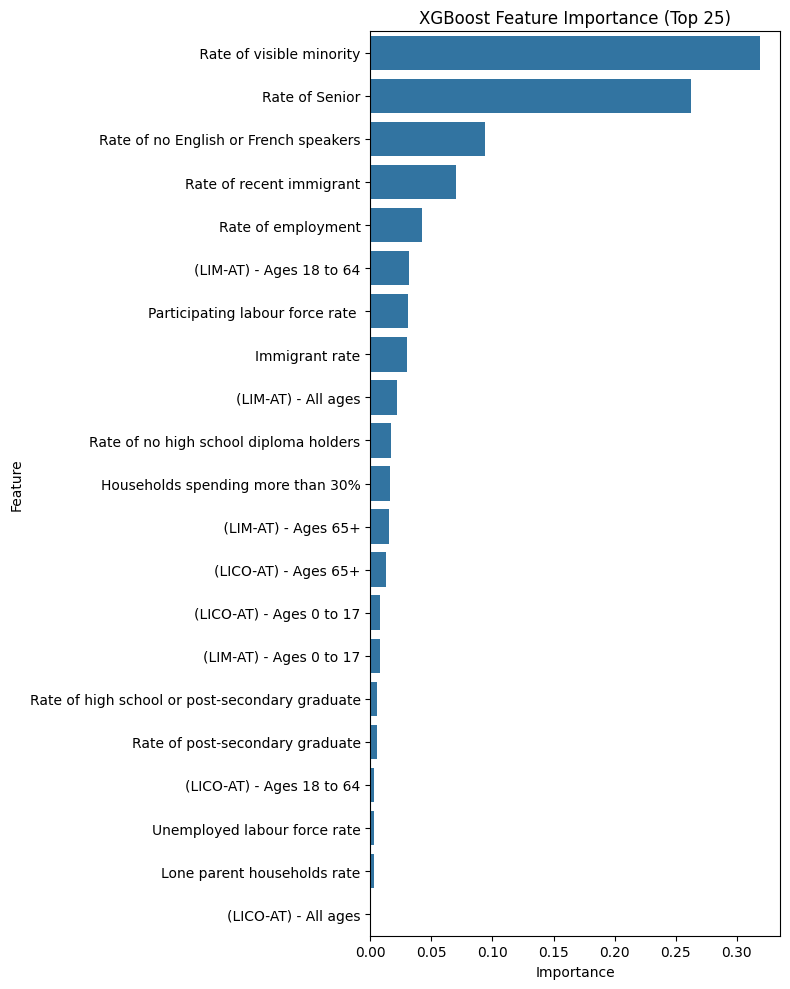

--- XGBoost (Mortality) ---
R²: 0.9032
MAE: 2.0914
RMSE:2.9179


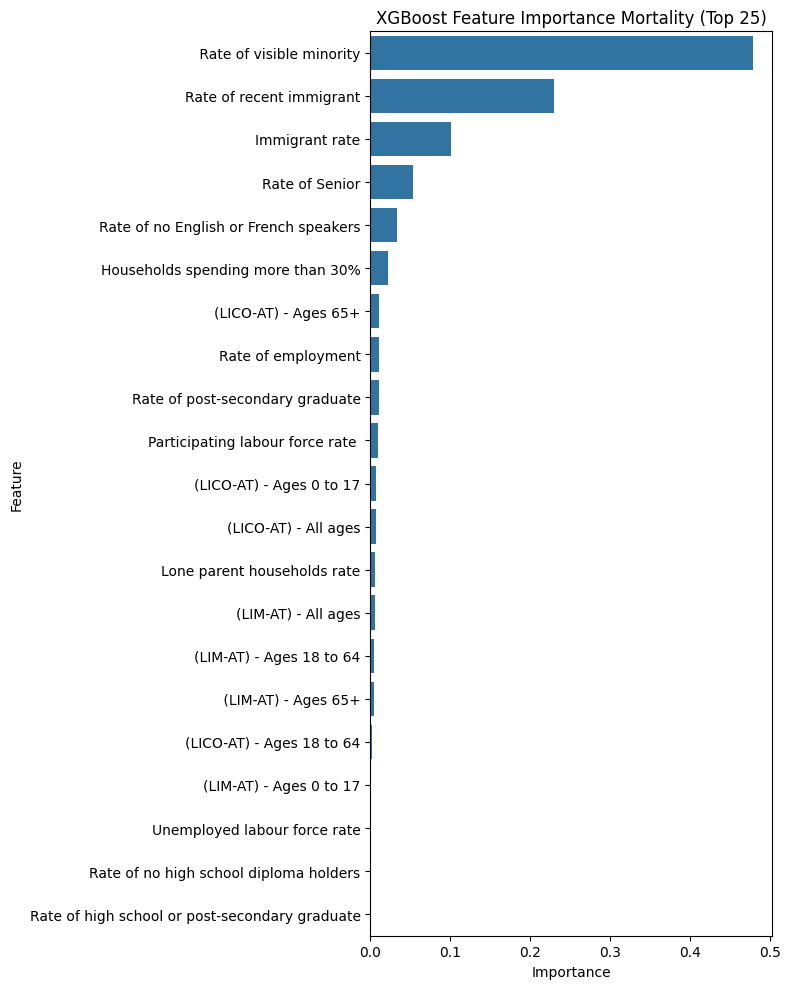

In [12]:
# %%
# ===============================
# Step 7: Robust Model - XGBoost
# ===============================
if xgb_available:
    xgb_inc = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        verbosity=0
    )
    xgb_inc.fit(X_train_inc, y_train_inc, eval_set=[(X_test_inc, y_test_inc)], verbose=False)
    y_pred_xgb_inc = xgb_inc.predict(X_test_inc)
    metrics_xgb_inc = regression_metrics(y_test_inc, y_pred_xgb_inc)
    print_metrics('XGBoost (Incidence)', metrics_xgb_inc)


    # Feature importance
    imp = xgb_inc.feature_importances_
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': imp}).sort_values('Importance', ascending=False)
    plt.figure(figsize=(8, 10))
    sns.barplot(x='Importance', y='Feature', data=imp_df.head(25))
    plt.title('XGBoost Feature Importance (Top 25)')
    plt.tight_layout()
    plt.show()
else:
    print('XGBoost not available — install xgboost to run the robust model.')


# XGBoost for mortality
if xgb_available:
    xgb_m = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        verbosity=0
    )
    xgb_m.fit(X_train_mort, y_train_mort, eval_set=[(X_test_mort, y_test_mort)], verbose=False)
    y_pred_xgb_mort = xgb_m.predict(X_test_mort)
    metrics_xgb_mort = regression_metrics(y_test_mort, y_pred_xgb_mort)
    print_metrics('XGBoost (Mortality)', metrics_xgb_mort)
    # Feature importance
    imp = xgb_m.feature_importances_
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': imp}).sort_values('Importance', ascending=False)
    plt.figure(figsize=(8, 10))
    sns.barplot(x='Importance', y='Feature', data=imp_df.head(25))
    plt.title('XGBoost Feature Importance Mortality (Top 25)')
    plt.tight_layout()
    plt.show()
else:
    print('XGBoost not available — install xgboost to run the robust model.')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 43, number of used features: 21
[LightGBM] [Info] Start training from score 166.243751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

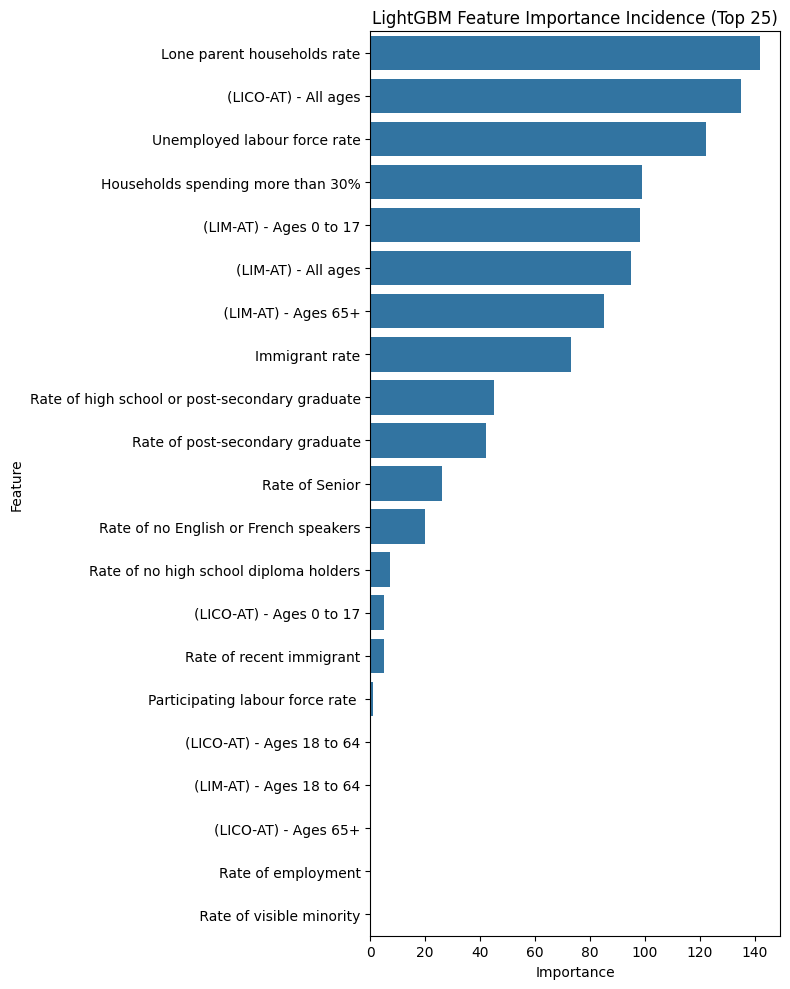

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 43, number of used features: 21
[LightGBM] [Info] Start training from score 68.390276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

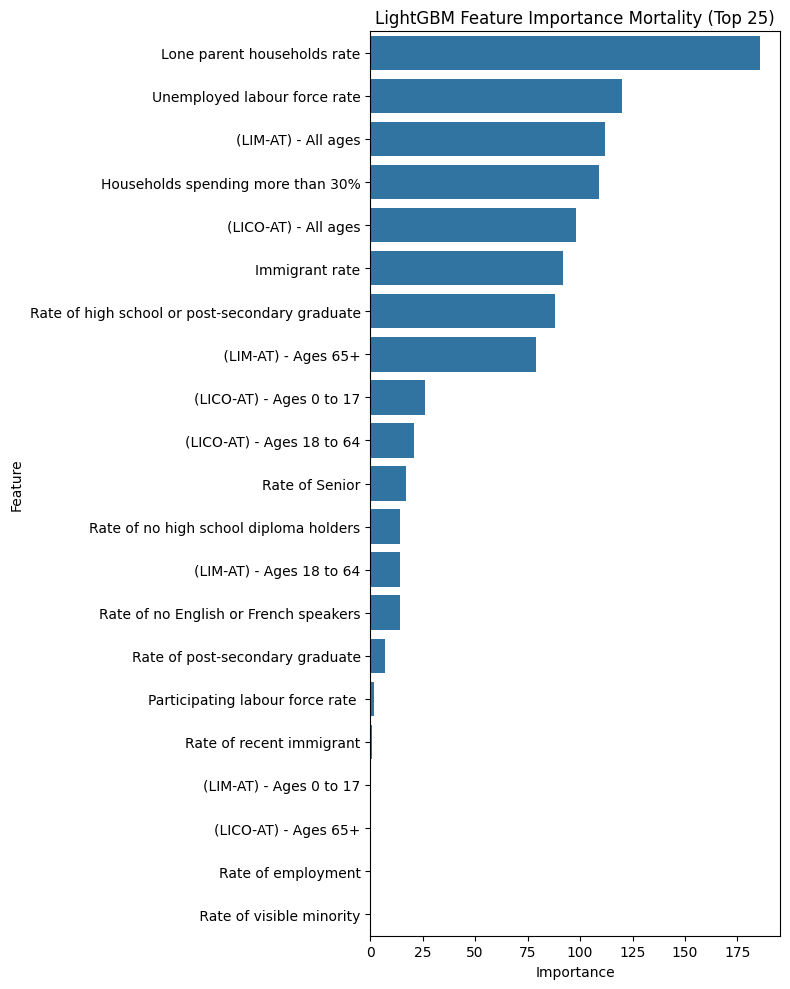

In [13]:
# %%
# ===============================
# Step 8: Alternative Robust Model
# ===============================
if lgb_available:
    lgb_inc = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE
    )
    lgb_inc.fit(X_train_inc, y_train_inc, eval_set=[(X_test_inc, y_test_inc)])
    y_pred_lgb_inc = lgb_inc.predict(X_test_inc)
    metrics_lgb_inc = regression_metrics(y_test_inc, y_pred_lgb_inc)
    print_metrics('LightGBM (Incidence)', metrics_lgb_inc)


    imp = lgb_inc.feature_importances_
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': imp}).sort_values('Importance', ascending=False)
    plt.figure(figsize=(8, 10))
    sns.barplot(x='Importance', y='Feature', data=imp_df.head(25))
    plt.title('LightGBM Feature Importance Incidence (Top 25)')
    plt.tight_layout()
    plt.show()
else:
    print('LightGBM not available — install lightgbm to run this model.')


# Mortality LightGBM
if lgb_available:
    lgb_m = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE
    )
    lgb_m.fit(X_train_mort, y_train_mort, eval_set=[(X_test_mort, y_test_mort)])
    y_pred_lgb_mort = lgb_m.predict(X_test_mort)
    metrics_lgb_mort = regression_metrics(y_test_mort, y_pred_lgb_mort)
    print_metrics('LightGBM (Mortality)', metrics_lgb_mort)

    imp = lgb_m.feature_importances_
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': imp}).sort_values('Importance', ascending=False)
    plt.figure(figsize=(8, 10))
    sns.barplot(x='Importance', y='Feature', data=imp_df.head(25))
    plt.title('LightGBM Feature Importance Mortality (Top 25)')
    plt.tight_layout()
    plt.show()
else:
    print('LightGBM not available — install lightgbm to run this model.')


Generating SHAP for XGBoost (Incidence)


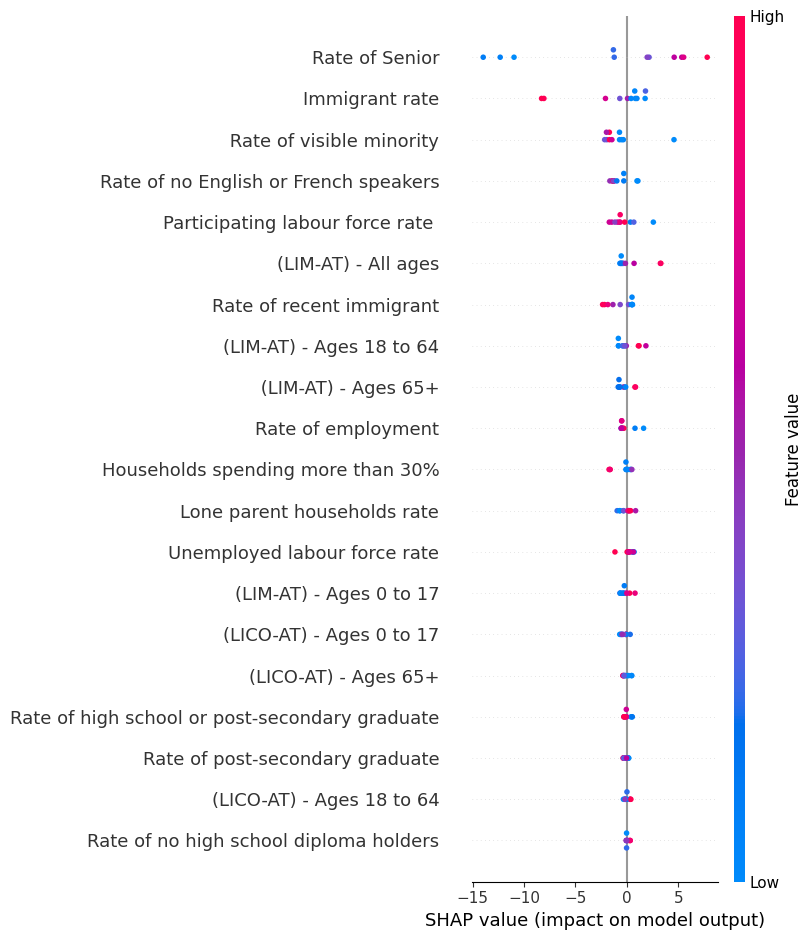


Generating SHAP for XGBoost (Mortality)


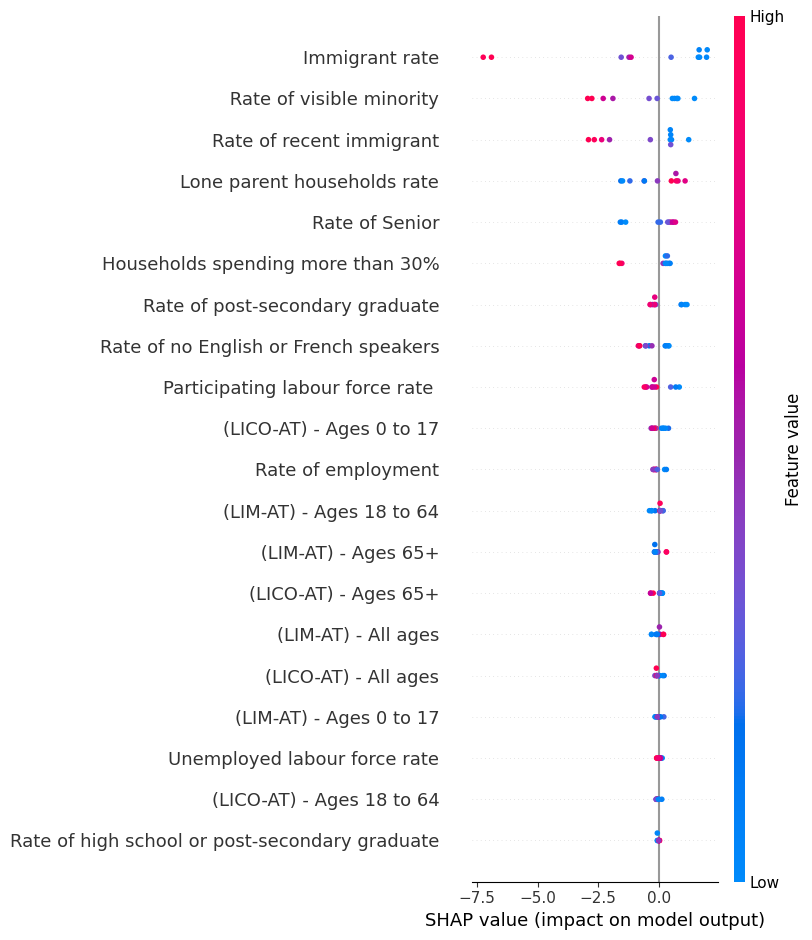

In [14]:
# %%
# ===============================
# Step 9: SHAP Interpretability
# ===============================
if shap_available:
    # Prefer tree explainer for tree models
    if xgb_available:
        print('\nGenerating SHAP for XGBoost (Incidence)')
        explainer = shap.Explainer(xgb_inc)
        shap_values = explainer(X_test_inc)
        shap.summary_plot(shap_values, features=X_test_inc, feature_names=feature_names)


        print('\nGenerating SHAP for XGBoost (Mortality)')
        explainer_m = shap.Explainer(xgb_m)
        shap_values_m = explainer_m(X_test_mort)
        shap.summary_plot(shap_values_m, features=X_test_mort, feature_names=feature_names)
    elif lgb_available:
        print('\nGenerating SHAP for LightGBM (Incidence)')
        explainer = shap.Explainer(lgb_inc)
        shap_values = explainer(X_test_inc)
        shap.summary_plot(shap_values, features=X_test_inc, feature_names=feature_names)


        print('\nGenerating SHAP for LightGBM (Mortality)')
        explainer_m = shap.Explainer(lgb_m)
        shap_values_m = explainer_m(X_test_mort)
        shap.summary_plot(shap_values_m, features=X_test_mort, feature_names=feature_names)
    else:
        # Fallback: SHAP for linear model (kernel explainer is slow) — use coef-based bar
        print('SHAP tree explainer unavailable. Showing coefficient bar plots for Lasso.')
        plt.figure(figsize=(8, 10))
        sns.barplot(x='Coefficient', y='Feature', data=coef_inc.head(25))
        plt.title('Lasso Coefficients (Incidence)')
        plt.tight_layout()
        plt.show()
else:
    print('SHAP not installed — install shap to run interpretability plots.')

In [15]:
# %%
# ===============================
# Step 10: Save Models & Scaler
# ===============================
import joblib
import os
os.makedirs('models', exist_ok=True)


# Save scaler and feature names
joblib.dump(scaler, 'models/scaler.joblib')
joblib.dump(feature_names, 'models/feature_names.joblib')


# Save linear and lasso
joblib.dump(lin, 'models/linear_inc.joblib')
joblib.dump(lasso_inc, 'models/lasso_inc.joblib')
joblib.dump(lin_m, 'models/linear_mort.joblib')
joblib.dump(lasso_mort, 'models/lasso_mort.joblib')


if xgb_available:
    joblib.dump(xgb_inc, 'models/xgb_inc.joblib')
    joblib.dump(xgb_m, 'models/xgb_mort.joblib')
if lgb_available:
    joblib.dump(lgb_inc, 'models/lgb_inc.joblib')
    joblib.dump(lgb_m, 'models/lgb_mort.joblib')


print('Models saved to /models')

Models saved to /models


In [16]:
# %%
# ===============================
# Step 11: Short Interpretation & Next Steps
# ===============================
print('\nInterpretation summary:')
print('- Compare model metrics above. Gradient-boosted models (XGBoost/LightGBM) generally outperform linear models when there are nonlinearities and noisy features.')
print('- Use SHAP outputs (if available) to identify top SDOH drivers of higher incidence/mortality.')
print('- Next steps: consider grouping features, adding spatial features (neighbor PHU rates), or ensembling models for production.')


# Save a brief CSV with predictions for inspection
pred_df = pd.DataFrame({
    'Geography_clean': merged['Geography_clean'].values,
    'Incidence_Rate': y_inc,
    'Mortality_Rate': y_mort
})


# Attach predictions where available
# Use the indices from the DataFrame versions of the test sets
if xgb_available:
    pred_df['Pred_Inc_XGB'] = np.nan
    pred_df.loc[X_test_inc_df.index, 'Pred_Inc_XGB'] = y_pred_xgb_inc
    pred_df['Pred_Mort_XGB'] = np.nan
    pred_df.loc[X_test_mort_df.index, 'Pred_Mort_XGB'] = y_pred_xgb_mort

if lgb_available:
    pred_df['Pred_Inc_LGB'] = np.nan
    pred_df.loc[X_test_inc_df.index, 'Pred_Inc_LGB'] = y_pred_lgb_inc
    pred_df['Pred_Mort_LGB'] = np.nan
    pred_df.loc[X_test_mort_df.index, 'Pred_Mort_LGB'] = y_pred_lgb_mort


pred_df.to_csv('models/predictions_overview.csv', index=False)
print('Saved predictions_overview.csv')


Interpretation summary:
- Compare model metrics above. Gradient-boosted models (XGBoost/LightGBM) generally outperform linear models when there are nonlinearities and noisy features.
- Use SHAP outputs (if available) to identify top SDOH drivers of higher incidence/mortality.
- Next steps: consider grouping features, adding spatial features (neighbor PHU rates), or ensembling models for production.
Saved predictions_overview.csv


Conclusion: This study integrated cancer incidence and mortality data with comprehensive Social Determinants of Health SDOH indicators to examine how structural and socioeconomic conditions relate to cancer burden across Ontario's Public Health Units. Through data cleaning, feature selection, scaling, and the application of multiple modeling approaches—including Linear Regression, Lasso Regression, and LightGBM—the analysis explored both linear and nonlinear relationships between SDOH variables and cancer outcomes.

Across all modeling strategies, the findings consistently demonstrated that SDOH factors have a meaningful association with both cancer incidence and mortality, even though overall predictive accuracy remained moderate. Lasso Regression helped narrow down the most influential features, while LightGBM captured nonlinear effects, achieving R² values in the range of 0.31-0.38 for the available data.

Several SDOH indicators emerged as consistently influential across models:

-Economic barriers: low-income prevalence, unemployment, housing cost burden

-Housing and living instability

-Educational attainment levels

-Population vulnerability and marginalization indicators

These patterns align with existing public health research showing that communities facing greater socioeconomic disadvantage often experience higher cancer burdens. While the models are not yet suitable for precise prediction—due to limited sample size, regional variability, and multicollinearity—the analysis provides a strong exploratory framework linking social inequity to cancer outcomes in Ontario.

Future methodological improvements, such as additional feature engineering, spatial modeling, and the inclusion of more granular or longitudinal data, could substantially improve model performance. Nevertheless, the current results underscore the importance of addressing upstream social and structural determinants alongside traditional cancer control strategies to reduce inequities in cancer incidence and mortality across the province.